# k-means initialization

## Imports, with correct version shown

In [1]:
import matplotlib.pyplot as plt

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [3]:
import numpy as np
print('The numpy version is {}.'.format(np.__version__))

The numpy version is 2.1.3.


In [4]:
import scipy
print('The scipy version is {}.'.format(scipy.__version__))

The scipy version is 1.14.1.


The functions generating the datasets are given here:

In [5]:
import sklearn.datasets
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return "blobs", blobs, labels, 3

~~Implement the centroid initialization here. Right now, it returns a random initialization.~~

Implemented the given pseudocode below.

In [6]:
def dist(v, X): 
    '''
        :param v: the vector
        :param X: the matrix containing the other vectors
    '''
    return np.min([np.linalg.norm(v - X[:,s])**2 for s in range(X.shape[1])])

def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    indexes = rng.integers(low=0, high=n, size=r)

    i = indexes[np.argmin([np.sum([np.linalg.norm(D[j,:] - D[k,:])**2 for j in range(n)]) for k in indexes])] # argmin `stuff`
    X = np.array(D[i,:], ndmin=2).T
    s = 1
    while (s < r):
        print(X.shape)
        sumdist = np.sum([dist(D[j,:].T, X) for j in range(n)])
        indexes = rng.choice(n, size=l, p=[dist(D[k,:].T, X) / sumdist for k in range(n)]) # sample

        i = indexes[np.argmin([np.sum([dist(D[j,:].T, np.c_[X, D[k,:].T]) for j in range(n)]) for k in indexes])] # argmin `stuff`

        X = np.c_[X, D[i,:].T] # X += stuff
        s = s+1
    return X

Spectral clustering given by them

In [7]:
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''  
    np.random.seed(0)
    L = np.diag(np.array(W.sum(0))[0]) - W
    v0 = np.random.rand(min(L.shape))
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM", v0=v0)
    A = V[:,1:] #remove the first eigenvector, assuming that the graph is conected
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)

    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [8]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

## Running k-means on the blobs dataset
We generate the blobs dataset. Run kmeans based on the initialization technique. Finally, we plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [9]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

In [10]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)

(2, 1)
(2, 2)
6 iterations


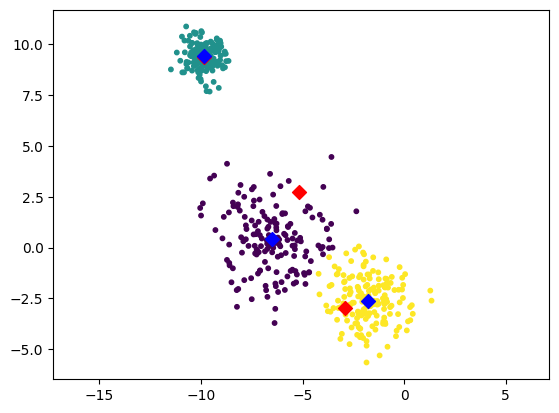

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D') # initial centroids are in red
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D') # computed centroids are in blue
plt.show()

## 2b
Getting the requested scores

In [12]:
import sklearn.metrics

ex2b1 = np.linalg.norm(D - np.matmul(Y, X.T))**2 / (D.shape[0] * D.shape[1])
blob_nmi = sklearn.metrics.normalized_mutual_info_score(labels, np.argmax(Y, axis=1))
ex2b1, blob_nmi

(np.float64(1.2345652376488239), np.float64(0.9527380045058215))

## Running spectral clustering on the two moons dataset
We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [13]:
dataID, D, labels, r = generateMoons(0.05,n)

(2, 1)
7 iterations


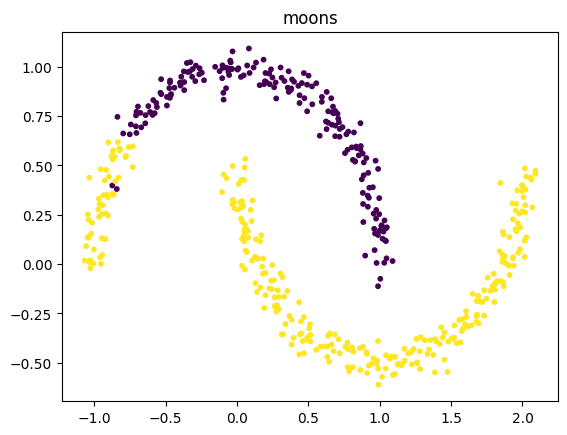

In [14]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
W = kneighbors_graph(D,40,include_self=False) # was originally radius_neighbors_graph, I think we had to change this
Y = spectral_clustering(W,r,init_centroids_greedy_pp)

plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()

In [16]:
# kNNs = range(60, 70)
kNNs = [5, 10, 20, 40]
Ws = [kneighbors_graph(D,k,include_self=False) for k in kNNs]
Ys = [spectral_clustering(W,r,init_centroids_greedy_pp) for W in Ws]

moon_nmis = [sklearn.metrics.normalized_mutual_info_score(labels, np.argmax(Y, axis=1)) for Y in Ys]
moon_nmis

(2, 1)
3 iterations
(2, 1)
4 iterations
(2, 1)
18 iterations
(2, 1)
7 iterations


[np.float64(0.022379047015751063),
 np.float64(0.01607939366792436),
 np.float64(0.10240732324800805),
 np.float64(0.5951912982359792)]